APARTADO 4: ANÁLISIS DE DATOS
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset cargado: 300 películas × 30 variables

MODELO SUPERVISADO:
Exactitud: 0.689
AUC-ROC: 0.703
Exactitud CV (5-fold): 0.683 ± 0.065
Importancia de variables:
  votos: 0.287
  presupuesto_millones: 0.230
  puntuacion: 0.227
  duracion_minutos: 0.206
  es_usa: 0.049


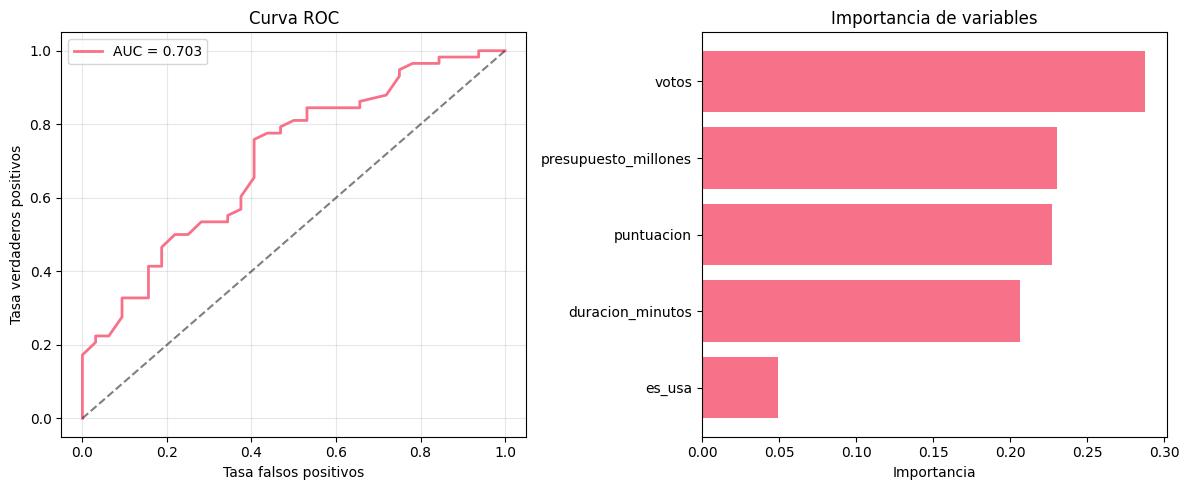


MODELO NO SUPERVISADO:
Número de clusters: 4
  Cluster 0: 211 películas
  Cluster 1: 87 películas
  Cluster 2: 1 películas
  Cluster 3: 1 películas

Características promedio por cluster:
         puntuacion      votos  duracion_minutos    roi  presupuesto_millones
cluster                                                                      
0              6.31   20651.00            102.85    6.5                 18.58
1              7.41   56494.82            132.43    6.0                 30.85
2              7.80  100664.00            131.00    0.0              30000.00
3              4.70   13696.00             98.00  214.5                  0.10


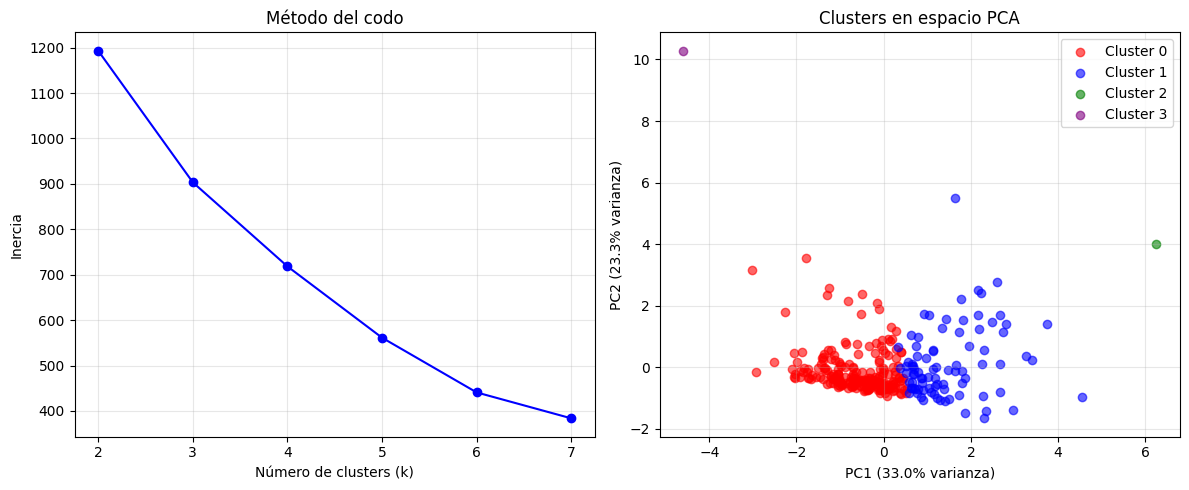


HIPÓTESIS 1: Puntuaciones USA vs No-USA
USA: 210 películas (Media: 6.460)
No-USA: 90 películas (Media: 7.029)
Normalidad USA: p=0.0186
Normalidad No-USA: p=0.0069
Homocedasticidad: p=0.0378
Mann-Whitney U: p=0.0000
Resultado: RECHAZAR H0

HIPÓTESIS 2: ROI por género
Drama: 71 películas (ROI medio: 4.44)
Comedia: 58 películas (ROI medio: 8.74)
Ciencia ficción: 29 películas (ROI medio: 7.70)
Aventuras: 26 películas (ROI medio: 4.23)
Terror: 23 películas (ROI medio: 21.17)
Kruskal-Wallis: p=0.0003
Resultado: RECHAZAR H0

HIPÓTESIS 3: Correlación FA-IMDB
Pares válidos: 299
Correlación Spearman: r=0.8629, p=0.0000
Resultado: RECHAZAR H0
Correlación FUERTE (0.863)

RESUMEN DE RESULTADOS
MODELO SUPERVISADO:
Exactitud: 68.9%
AUC-ROC: 0.703
Variable más predictiva: votos

MODELO NO SUPERVISADO:
4 clusters identificados

PRUEBAS DE HIPÓTESIS:
USA vs No-USA: Diferencias significativas
ROI por género: Diferencias significativas
Correlación FA-IMDB: r=0.863 (Significativa)
El análisis revela:
- Pr

In [8]:
# =======================================
# ANÁLISIS DE DATOS
# =======================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import shapiro, levene, mannwhitneyu, kruskal, spearmanr
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("APARTADO 4: ANÁLISIS DE DATOS")
print("="*70)

# CONFIGURACIÓN Y CARGA
plt.style.use('default')
sns.set_palette("husl")

from google.colab import drive
drive.mount("/content/drive")

df = pd.read_csv("/content/drive/MyDrive/Tipología/PR2/datasets/paso03-peliculas_filmaffinity_1980-1989_limpio.csv",
                 sep=';', encoding='utf-8')

print(f"Dataset cargado: {df.shape[0]} películas × {df.shape[1]} variables")

# =========================================
# 4.1A - MODELO SUPERVISADO: RANDOM FOREST
# =========================================

# Preparar datos
features = ['puntuacion', 'votos', 'duracion_minutos', 'presupuesto_millones', 'es_usa']
X = df[features].fillna(df[features].median())
y = df['exito_comercial']

# División y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluación
accuracy = rf_model.score(X_test, y_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
cv_scores = cross_val_score(rf_model, X, y, cv=5)

print(f"\nMODELO SUPERVISADO:")
print(f"Exactitud: {accuracy:.3f}")
print(f"AUC-ROC: {auc_score:.3f}")
print(f"Exactitud CV (5-fold): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Importancia de variables
importances = pd.DataFrame({
    'variable': features,
    'importancia': rf_model.feature_importances_
}).sort_values('importancia', ascending=False)

print("Importancia de variables:")
for _, row in importances.iterrows():
    print(f"  {row['variable']}: {row['importancia']:.3f}")

# Visualización modelo supervisado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, linewidth=2, label=f'AUC = {auc_score:.3f}')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('Tasa falsos positivos')
axes[0].set_ylabel('Tasa verdaderos positivos')
axes[0].set_title('Curva ROC')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Importancia de variables
axes[1].barh(importances['variable'], importances['importancia'])
axes[1].set_xlabel('Importancia')
axes[1].set_title('Importancia de variables')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# =========================================
# 4.1B - MODELO NO SUPERVISADO: CLUSTERING
# =========================================

# Variables para clustering
cluster_vars = ['puntuacion', 'votos', 'duracion_minutos', 'roi', 'presupuesto_millones']
X_cluster = df[cluster_vars].fillna(df[cluster_vars].median())

# Normalización y clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# K-means con k=4
n_clusters = 4
kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

print(f"\nMODELO NO SUPERVISADO:")
print(f"Número de clusters: {n_clusters}")

# Distribución por cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
for i, count in enumerate(counts):
    print(f"  Cluster {i}: {count} películas")

# Características por cluster
df_clustered = df.copy()
df_clustered['cluster'] = cluster_labels
cluster_stats = df_clustered.groupby('cluster')[cluster_vars].mean()
print(f"\nCaracterísticas promedio por cluster:")
print(cluster_stats.round(2))

# Visualización clustering
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Método del codo
inertias = []
K_range = range(2, 8)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Número de clusters (k)')
axes[0].set_ylabel('Inercia')
axes[0].set_title('Método del codo')
axes[0].grid(True, alpha=0.3)

# PCA visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
colors = ['red', 'blue', 'green', 'purple']

for i in range(n_clusters):
    mask = cluster_labels == i
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1],
                   c=colors[i], label=f'Cluster {i}', alpha=0.6)

axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
axes[1].set_title('Clusters en espacio PCA')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ===========================
# 4.2 - PRUEBAS DE HIPÓTESIS
# ===========================

alpha = 0.05

# HIPÓTESIS 1: Puntuaciones USA vs No-USA
puntuacion_usa = df[df['es_usa'] == 1]['puntuacion'].dropna()
puntuacion_no_usa = df[df['es_usa'] == 0]['puntuacion'].dropna()

print(f"\nHIPÓTESIS 1: Puntuaciones USA vs No-USA")
print(f"USA: {len(puntuacion_usa)} películas (Media: {puntuacion_usa.mean():.3f})")
print(f"No-USA: {len(puntuacion_no_usa)} películas (Media: {puntuacion_no_usa.mean():.3f})")

# Tests de normalidad y homocedasticidad
shapiro_usa = shapiro(puntuacion_usa)
shapiro_no_usa = shapiro(puntuacion_no_usa)
levene_stat, levene_p = levene(puntuacion_usa, puntuacion_no_usa)

print(f"Normalidad USA: p={shapiro_usa.pvalue:.4f}")
print(f"Normalidad No-USA: p={shapiro_no_usa.pvalue:.4f}")
print(f"Homocedasticidad: p={levene_p:.4f}")

# Mann-Whitney (datos no normales)
stat, p_valor_1 = mannwhitneyu(puntuacion_usa, puntuacion_no_usa, alternative='two-sided')
print(f"Mann-Whitney U: p={p_valor_1:.4f}")
print(f"Resultado: {'RECHAZAR H0' if p_valor_1 < alpha else 'NO RECHAZAR H0'}")

# HIPÓTESIS 2: ROI por género
top_genres = df['genero_principal'].value_counts().head(5).index.tolist()
df_genres = df[df['genero_principal'].isin(top_genres)]

print(f"\nHIPÓTESIS 2: ROI por género")
groups = []
for genre in top_genres:
    genre_roi = df_genres[df_genres['genero_principal'] == genre]['roi'].dropna()
    if len(genre_roi) >= 5:
        groups.append(genre_roi)
        print(f"{genre}: {len(genre_roi)} películas (ROI medio: {genre_roi.mean():.2f})")

# Kruskal-Wallis (datos no normales)
stat, p_valor_2 = kruskal(*groups)
print(f"Kruskal-Wallis: p={p_valor_2:.4f}")
print(f"Resultado: {'RECHAZAR H0' if p_valor_2 < alpha else 'NO RECHAZAR H0'}")

# HIPÓTESIS 3: Correlación FilmAffinity vs IMDB
valid_scores = df.dropna(subset=['puntuacion', 'imdb_puntuacion'])
fa_scores = valid_scores['puntuacion']
imdb_scores = valid_scores['imdb_puntuacion']

print(f"\nHIPÓTESIS 3: Correlación FA-IMDB")
print(f"Pares válidos: {len(valid_scores)}")

# Correlación de Spearman
corr_coef, p_valor_3 = spearmanr(fa_scores, imdb_scores)
print(f"Correlación Spearman: r={corr_coef:.4f}, p={p_valor_3:.4f}")
print(f"Resultado: {'RECHAZAR H0' if p_valor_3 < alpha else 'NO RECHAZAR H0'}")

if p_valor_3 < alpha:
    fuerza = "FUERTE" if abs(corr_coef) > 0.7 else "MODERADA" if abs(corr_coef) > 0.5 else "DÉBIL"
    print(f"Correlación {fuerza} ({corr_coef:.3f})")

# RESUMEN FINAL
print(f"\n{'='*50}")
print("RESUMEN DE RESULTADOS")
print(f"{'='*50}")
print(f"MODELO SUPERVISADO:")
print(f"Exactitud: {accuracy:.1%}")
print(f"AUC-ROC: {auc_score:.3f}")
print(f"Variable más predictiva: {importances.iloc[0]['variable']}")

print(f"\nMODELO NO SUPERVISADO:")
print(f"{n_clusters} clusters identificados")

print(f"\nPRUEBAS DE HIPÓTESIS:")
print(f"USA vs No-USA: {'Diferencias significativas' if p_valor_1 < alpha else 'Sin diferencias'}")
print(f"ROI por género: {'Diferencias significativas' if p_valor_2 < alpha else 'Sin diferencias'}")
print(f"Correlación FA-IMDB: r={corr_coef:.3f} ({'Significativa' if p_valor_3 < alpha else 'No significativa'})")

print(f"El análisis revela:")
print(f"- Predictibilidad del éxito comercial con {accuracy:.1%} de exactitud")
print(f"- Segmentación clara en {n_clusters} perfiles de películas")
print(f"- Consistencia entre plataformas de valoración (r={corr_coef:.3f})")